In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_validate, KFold
import statsmodels.graphics.api as smg
from scipy.stats import spearmanr

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

After doing testing in Out of the Park Baseball 22 to determine any engine changes had occured from the previous version, I ran into some peculiar results concerning the handedness of a batter, compared to that of the pitcher they were facing. Namely, opposite side of the plate batters (LHB vs RHP, and RHB vs LHB) were getting penalties to their expected performance in the OOTP22 engine, which is not what the expected outcome would normally be.

[It is well documented that batters that the opposite side of the plate from the hand the pitcher uses to throw have an advantage](https://en.wikipedia.org/wiki/Lefty-righty_switch), so I won't be documenting that within this notebook. What I will be attempting to prove is the opposite is true in OOTP22 currently.

This notebook will be primarily separated into four different sections:
* Batters against only Right-Handed Pitchers utilizing the Simulation Module
* Batters against only Right-Handed Pitchers after a single season.
* Batters against only Left-Handed Pitchers after a single season.
* Batters against only Right-Handed Pitchers utilizing the Simulation Module in OOTP21
    
In the first three sections, batters that hit from the opposite side of the plate will be shown to have a penalty to their expected outcomes when all other ratings would be equal. In the last example, the reverse is true, and opposite side of the plate batters get the expected boost. 

### Setup for each test
Each test utilized the MLB quickstart within Out of the Park Baseball for its version. Every team was moved to play in the same ballpark, with that park having its park factors set to 1.000 across the board, and its wind set to 0mph. Player fatigue, injuries and suspensions were all turned off. For tests that were conducted over the course of a full season, ratehr than using the Simulation Module, player development and AI roster moves were also disabled.

#### Test One: Batters against RHP in the Simulation Module

This test was conducted in the Simulation Module utilziing a script I had written to automatically parse the reports that were generated. Each team played the other 29 MLB teams a total of 2,430 games, which is the equivalent of 15 MLB seasons. After doing the preliminary test setup outlined above, every left-handed pitcher in the world was retired, and the AI was then used to setup every team's roster. I had done a test prior to this where I had just flipped all left-handed pitchers in MLB over to right-handed pitchers and saw similar results, but wanted to ensure that there was no residual impact from having a RHP who might be better against LHB with their control and movement ratings.

In the cell below I load the data from the test. The ratings I will be using for every test will primarily be the batting ratings directly from the player_batting database table against the handedness of the pitcher in question, the groundball and flyball tendancy of the batter, and two running raitings from the players table. The minimium number of at-bats by anyone included in this data set is 20,306, while the maximium is 310,851. 

In [2]:
df = pd.read_csv('OOTP22_Batting_3.csv', index_col='player_id')
df

,running_ratings_speed,batting_ratings_vsr_babip,batting_ratings_vsr_gap,batting_ratings_vsr_power,batting_ratings_vsr_eye,batting_ratings_vsr_strikeouts,batting_ratings_misc_gb_hitter_type,batting_ratings_misc_fb_hitter_type,bats,AB,AVG,OBP,SLG,wOBA
player_id,,,,,,,,,,,,,,
12,65,83,76,170,149,65,3,2,2,244050,0.209,0.309,0.441,0.3307
15,169,134,158,120,96,126,2,2,1,290504,0.296,0.349,0.502,0.3701
16,63,154,111,147,150,83,2,2,2,271746,0.260,0.363,0.473,0.3677
28,53,144,105,111,131,87,2,2,1,252019,0.271,0.360,0.438,0.3537
42,24,75,60,104,99,58,2,2,1,181051,0.203,0.263,0.345,0.2712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36418,65,87,63,50,88,115,1,1,2,252092,0.230,0.288,0.325,0.2751
36517,52,107,144,117,99,135,2,2,1,251714,0.280,0.339,0.471,0.3541
36568,43,121,115,113,107,135,3,2,1,262984,0.275,0.338,0.448,0.3452


In [3]:
np.min(df['AB'])

20306

In [4]:
np.max(df['AB'])

310851

Below is a correlation matrix of the various hitting attributes that are on 1 - 200 scale from the databse. Given the low correlation coefficients (the highest is .42 between BABIP and GAP), the risk for multi-colinearity is low. It would be higher if I had included BABIP, Avoid Ks and Contact in the model, but those were separated out.

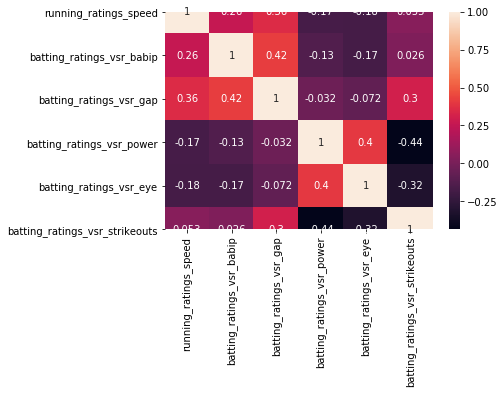

In [5]:
corr = df[['running_ratings_speed', 'batting_ratings_vsr_babip',
       'batting_ratings_vsr_gap', 'batting_ratings_vsr_power',
       'batting_ratings_vsr_eye', 'batting_ratings_vsr_strikeouts']].corr(method = 'spearman')
sns.heatmap(corr, annot = True)

plt.show()

In [6]:
df.columns

Index(['running_ratings_speed', 'batting_ratings_vsr_babip',
       'batting_ratings_vsr_gap', 'batting_ratings_vsr_power',
       'batting_ratings_vsr_eye', 'batting_ratings_vsr_strikeouts',
       'batting_ratings_misc_gb_hitter_type',
       'batting_ratings_misc_fb_hitter_type', 'bats', 'AB', 'AVG', 'OBP',
       'SLG', 'wOBA'],
      dtype='object')

The above printout shows all the columns in the dataset. The "ratings" columns are all on the 1-200 scale that the databse uses.

The bats column in the data is the side of the plate the hitter bats from, where 1 is Right, 2 is Left and 3 is someone who is a Switch hitter. I will leave switch-hitters listed as such for this first model build, but the assumption is the game would automatically have a switch-hitter bat from the opposite side of the plate of the pitcher.

Both the groundball and flyball hitter types are stored as an integer in the database and correspond to the displayed value in the game, with 1 being normal, 2 being spray, 3 being pull and 4 being extreme pull for the groundball type. 

These three columns are all categorical variables, and should be treated as such in the model building process. In R this could be done by just converting them to factors and building a model, but with Scikit-Learn an extra step has to be done. In the code block below, they are converted to categorical variables, and then each type is split out into a separate column, with a 1 being they are that type, and a 0 being they are not.

In [7]:
df[['bats', 'batting_ratings_misc_gb_hitter_type', 'batting_ratings_misc_fb_hitter_type']] = df[['bats', 'batting_ratings_misc_gb_hitter_type', 'batting_ratings_misc_fb_hitter_type']].astype('category')

df = pd.get_dummies(df)
df.head()

,running_ratings_speed,batting_ratings_vsr_babip,batting_ratings_vsr_gap,batting_ratings_vsr_power,batting_ratings_vsr_eye,batting_ratings_vsr_strikeouts,AB,AVG,OBP,SLG,...,batting_ratings_misc_gb_hitter_type_0,batting_ratings_misc_gb_hitter_type_1,batting_ratings_misc_gb_hitter_type_2,batting_ratings_misc_gb_hitter_type_3,batting_ratings_misc_fb_hitter_type_0,batting_ratings_misc_fb_hitter_type_1,batting_ratings_misc_fb_hitter_type_2,bats_1,bats_2,bats_3
player_id,,,,,,,,,,,,,,,,,,,,,
12,65,83,76,170,149,65,244050,0.209,0.309,0.441,...,0,0,0,1,0,0,1,0,1,0
15,169,134,158,120,96,126,290504,0.296,0.349,0.502,...,0,0,1,0,0,0,1,1,0,0
16,63,154,111,147,150,83,271746,0.260,0.363,0.473,...,0,0,1,0,0,0,1,0,1,0
28,53,144,105,111,131,87,252019,0.271,0.360,0.438,...,0,0,1,0,0,0,1,1,0,0
42,24,75,60,104,99,58,181051,0.203,0.263,0.345,...,0,0,1,0,0,0,1,1,0,0


With the categorical variables adequately converted to use in anaylsis, it's time to start looking at some plots of the data. Below is a pairs plot with every column in the dataset plotted against each other. You should be able to right-click and view the image, allowing it to be expanded. The plot was also saved as a png and included in this github repo.

It doesn't yield too much we wouldn't expect. Higher BABIP scores lead to higher AVG, OBP, SLG and wOBA. Higher eye leads to higher OBP. A higher power rating translates to higher slugging.

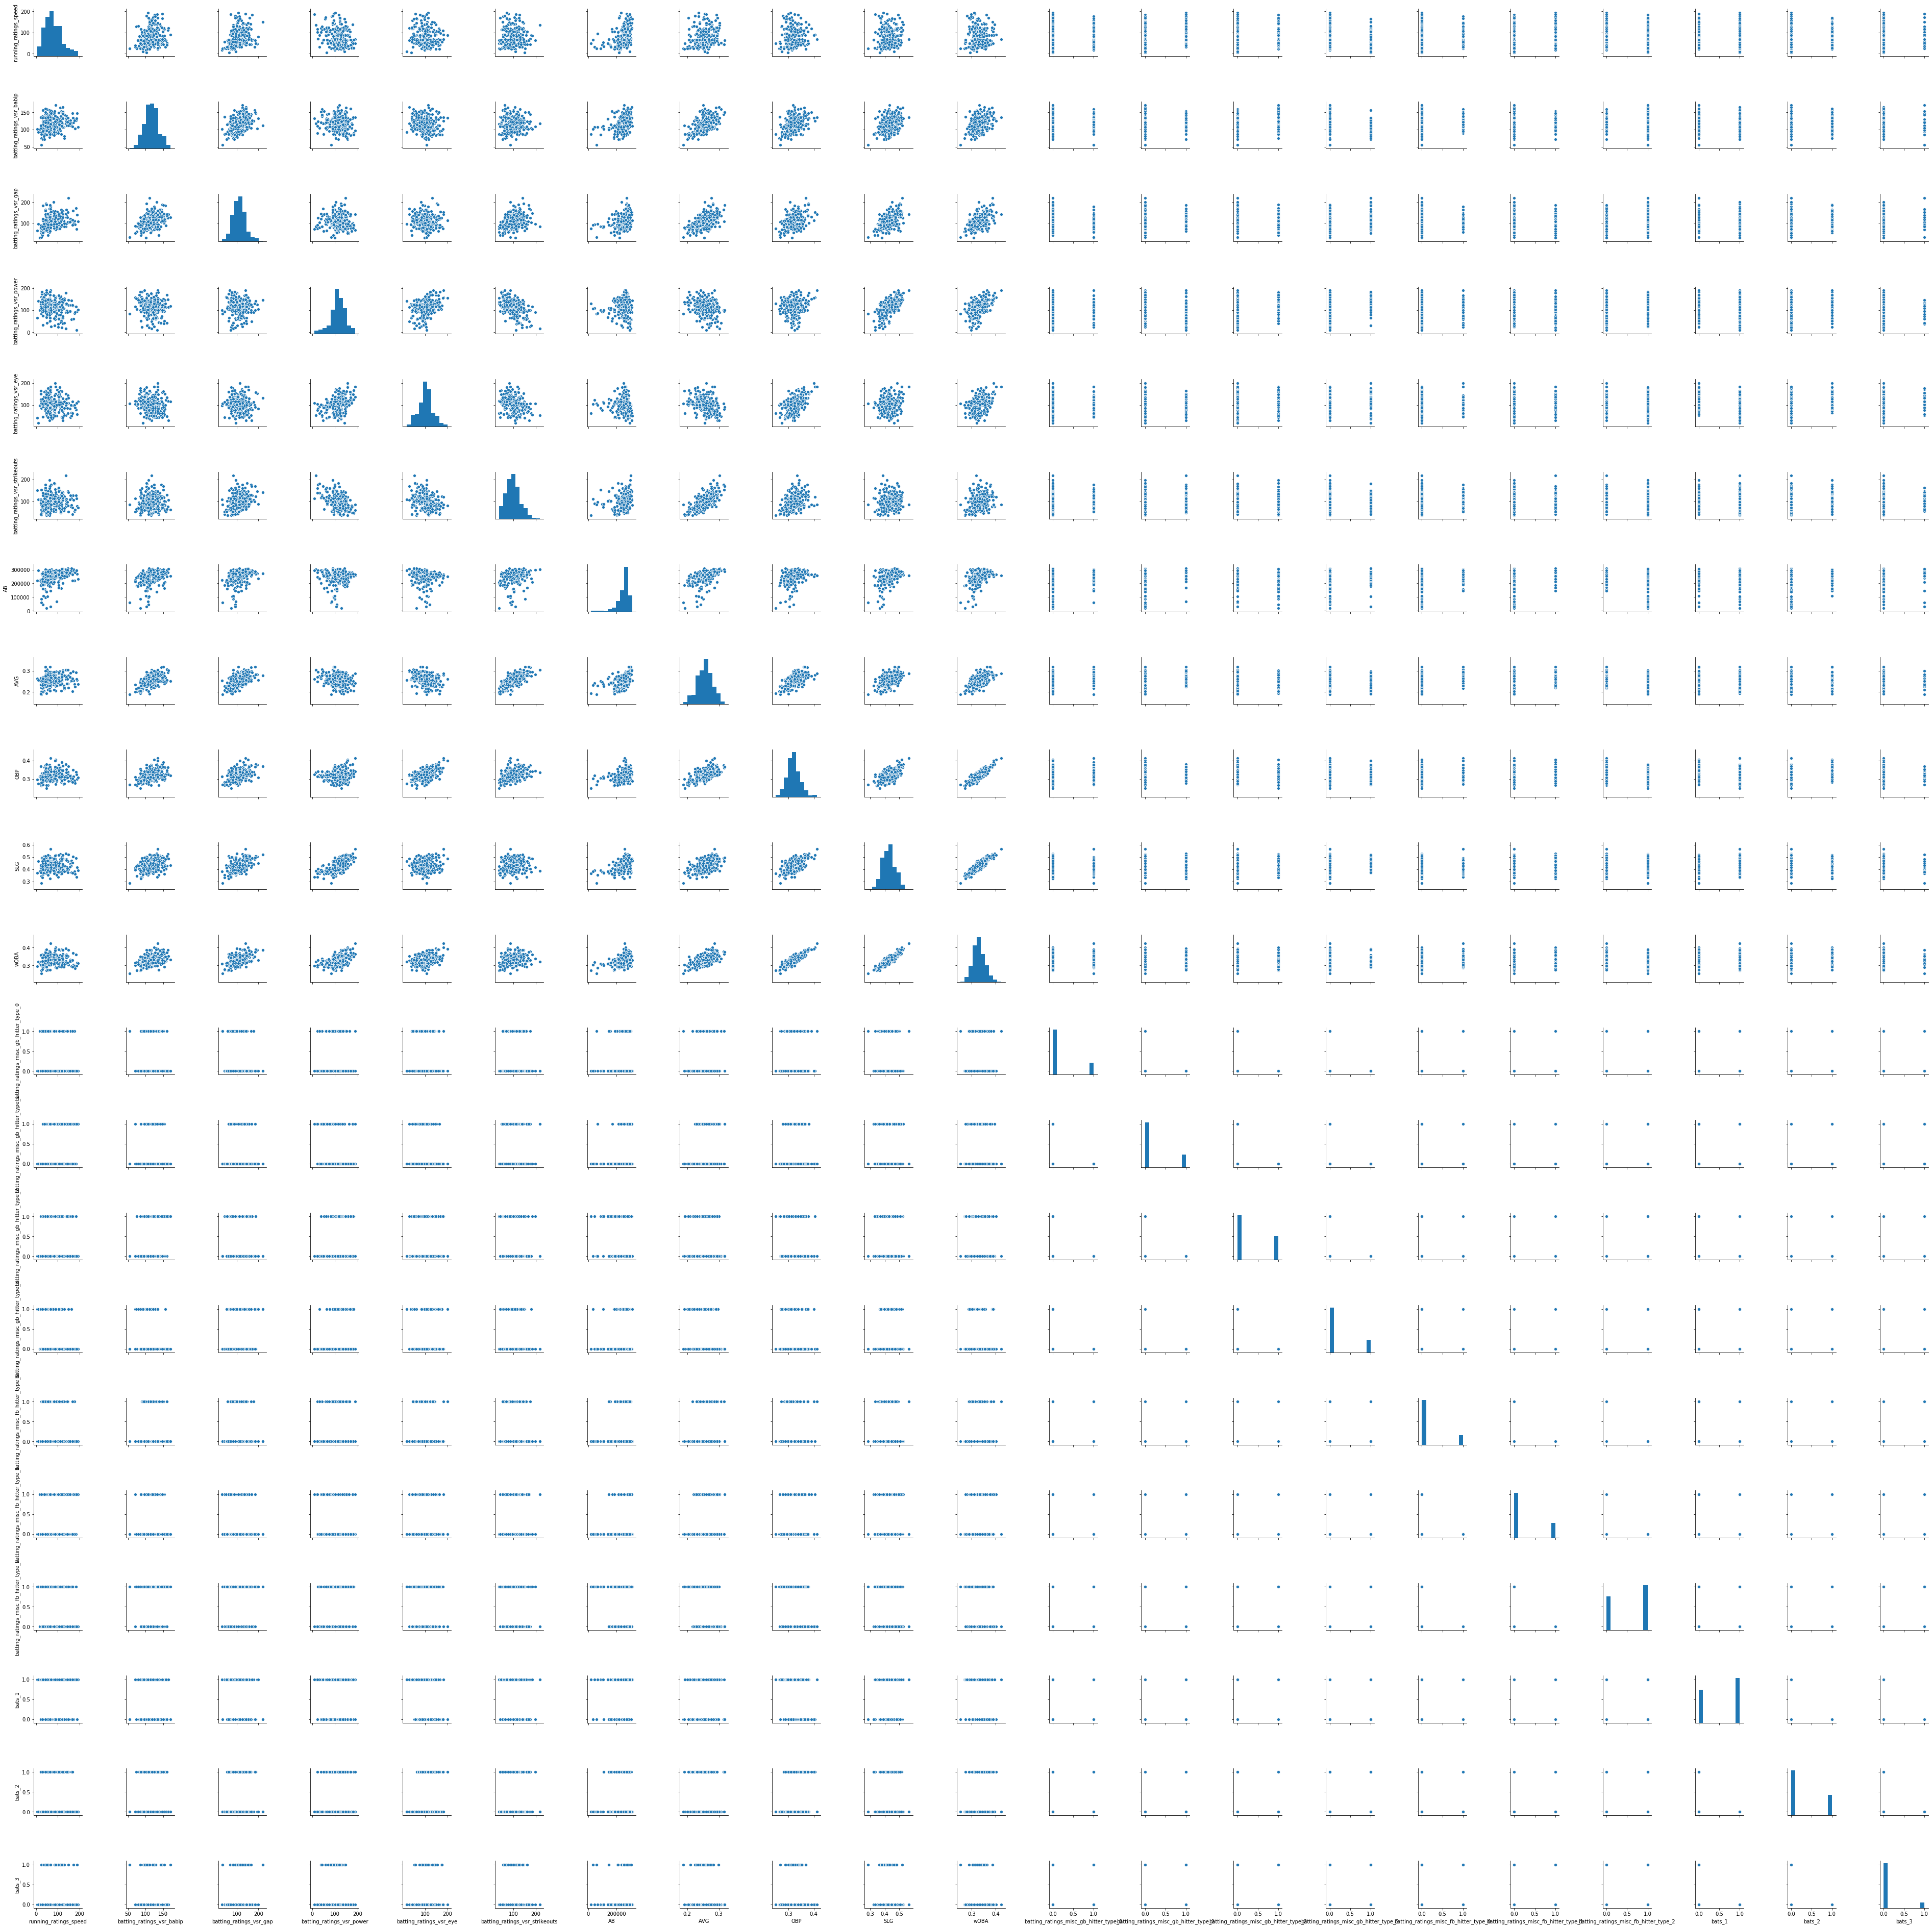

In [8]:
sns.pairplot(df)

But what I want to draw attention to is the relation of the batting side categories and the various hitting statistics included in the dataset. 

In this first plot, a player's slugging percentage is plotted against whether or not they are a left-handed batter (1 on the graph). Generally, left-handed batters have a small decrease to their SLG compared to non-left handed batters.

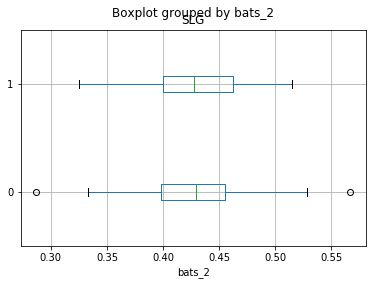

In [9]:
df.boxplot('SLG', by='bats_2', vert=False)

The same is true for batting average and left-handed batters.

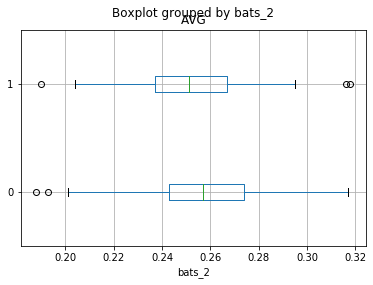

In [10]:
df.boxplot('AVG', by='bats_2', vert=False)

Since wOBA is not a statistic included in the Simulation Module reports, it was calculated [using the weights from this Fangraphs article.](https://library.fangraphs.com/offense/woba/) It's not going to be 100 percent accurate since things like inentional walks and sacrifices aren't also included, but it's as close as one can get with what's available without scraping each game log and generating weights from there.

In the plot below, at first glance it doesn't appear that wOBA is negatively impacted, but that will be shown to be false in a bit.

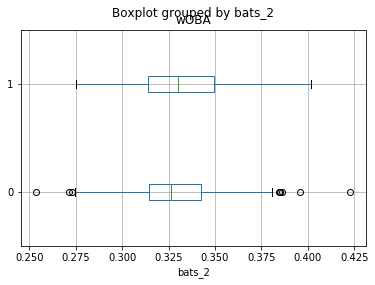

In [11]:
df.boxplot('wOBA', by='bats_2', vert=False)

For each model, I'll be using a simple linear regression implementation from the Scikit-Learn library. I am not going to spend too much time on optimizing models or doing feature engineering or elimination. I think the results will be clear as this notebook progresses.

In [12]:
variables = df.loc[:, ['running_ratings_speed', 'batting_ratings_vsr_babip',
       'batting_ratings_vsr_gap', 'batting_ratings_vsr_power',
       'batting_ratings_vsr_eye', 'batting_ratings_vsr_strikeouts',
        'batting_ratings_misc_gb_hitter_type_0',
       'batting_ratings_misc_gb_hitter_type_1',
       'batting_ratings_misc_gb_hitter_type_2',
       'batting_ratings_misc_gb_hitter_type_3',
       'batting_ratings_misc_fb_hitter_type_0',
       'batting_ratings_misc_fb_hitter_type_1',
       'batting_ratings_misc_fb_hitter_type_2', 'bats_1', 'bats_2', 'bats_3']]
variables

,running_ratings_speed,batting_ratings_vsr_babip,batting_ratings_vsr_gap,batting_ratings_vsr_power,batting_ratings_vsr_eye,batting_ratings_vsr_strikeouts,batting_ratings_misc_gb_hitter_type_0,batting_ratings_misc_gb_hitter_type_1,batting_ratings_misc_gb_hitter_type_2,batting_ratings_misc_gb_hitter_type_3,batting_ratings_misc_fb_hitter_type_0,batting_ratings_misc_fb_hitter_type_1,batting_ratings_misc_fb_hitter_type_2,bats_1,bats_2,bats_3
player_id,,,,,,,,,,,,,,,,
12,65,83,76,170,149,65,0,0,0,1,0,0,1,0,1,0
15,169,134,158,120,96,126,0,0,1,0,0,0,1,1,0,0
16,63,154,111,147,150,83,0,0,1,0,0,0,1,0,1,0
28,53,144,105,111,131,87,0,0,1,0,0,0,1,1,0,0
42,24,75,60,104,99,58,0,0,1,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36418,65,87,63,50,88,115,0,1,0,0,0,1,0,0,1,0
36517,52,107,144,117,99,135,0,0,1,0,0,0,1,1,0,0
36568,43,121,115,113,107,135,0,0,0,1,0,0,1,1,0,0


This first model is fitted against a player's batting average using all the available variables from the dataset. The coefficients for each variable can also be seen. If a lefty/righty matchups worked as we would expect, the coefficient for bats_2(LHB) and bats_3(Switch Hitters) would both be positive. Instead they are negative, meaning that all things being equal, they would have a lower expected batting average than a right-handed batter.

In [13]:
lr = linear_model.LinearRegression()

target = 'AVG'
lr.fit(variables, df[target])
dict(zip(variables.columns, lr.coef_))

{'running_ratings_speed': 2.545587637042242e-05,
 'batting_ratings_vsr_babip': 0.0006422294512815035,
 'batting_ratings_vsr_gap': 5.921061895633364e-05,
 'batting_ratings_vsr_power': 0.00021302263763818509,
 'batting_ratings_vsr_eye': 7.802847035153068e-06,
 'batting_ratings_vsr_strikeouts': 0.0006150629752274663,
 'batting_ratings_misc_gb_hitter_type_0': 0.004339349978887075,
 'batting_ratings_misc_gb_hitter_type_1': 0.003411655327251148,
 'batting_ratings_misc_gb_hitter_type_2': -0.0003426187724674761,
 'batting_ratings_misc_gb_hitter_type_3': -0.00740838653367074,
 'batting_ratings_misc_fb_hitter_type_0': -0.00017796710337415983,
 'batting_ratings_misc_fb_hitter_type_1': 0.0014244563817918528,
 'batting_ratings_misc_fb_hitter_type_2': -0.0012464892784176925,
 'bats_1': 0.008349535151812021,
 'bats_2': -0.004982920335507511,
 'bats_3': -0.003366614816304509}

Below is a plot of the residuals (the difference between the predicted value for the player and the actual value of the target) from the model.

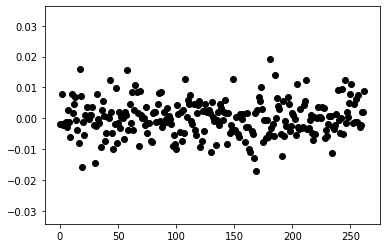

In [14]:
plt.scatter(df.reset_index().index, lr.predict(variables) - df[target], color='black')
plt.show()

In [15]:
r2_score(df[target], lr.predict(variables))

0.9455550972332657

In the next two codeblocks, I will just print off the coefficients for both OBP and SLG for a model fitted on the full dataset. From this point forward, every model will be shown with its residuals and r2 score.

In [16]:
target = 'OBP'
lr.fit(variables, df[target])
dict(zip(variables.columns, lr.coef_))

{'running_ratings_speed': 1.907917479360289e-05,
 'batting_ratings_vsr_babip': 0.0005873042928726047,
 'batting_ratings_vsr_gap': 5.439358567926159e-05,
 'batting_ratings_vsr_power': 0.0002365761585971136,
 'batting_ratings_vsr_eye': 0.0006513164913879927,
 'batting_ratings_vsr_strikeouts': 0.0005797685687509296,
 'batting_ratings_misc_gb_hitter_type_0': 0.005128990384204694,
 'batting_ratings_misc_gb_hitter_type_1': 0.0008835972403625274,
 'batting_ratings_misc_gb_hitter_type_2': 0.00027543940589988666,
 'batting_ratings_misc_gb_hitter_type_3': -0.006288027030467105,
 'batting_ratings_misc_fb_hitter_type_0': -0.0017932108403020247,
 'batting_ratings_misc_fb_hitter_type_1': 0.003397254218062784,
 'batting_ratings_misc_fb_hitter_type_2': -0.0016040433777607572,
 'bats_1': 0.006636433409279122,
 'bats_2': -0.0038515866962101452,
 'bats_3': -0.002784846713068975}

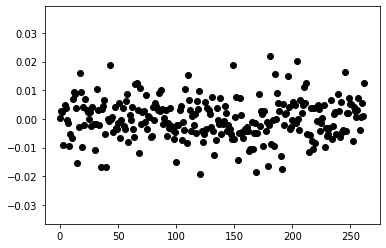

In [17]:
plt.scatter(df.reset_index().index, lr.predict(variables) - df[target], color='black')
plt.show()

In [18]:
r2_score(df[target], lr.predict(variables))

0.926464140888672

In [19]:
target = 'SLG'
lr.fit(variables, df[target])
dict(zip(variables.columns, lr.coef_))

{'running_ratings_speed': 5.47719891144608e-05,
 'batting_ratings_vsr_babip': 0.0007055398988908934,
 'batting_ratings_vsr_gap': 0.0003520243111582082,
 'batting_ratings_vsr_power': 0.0013343024583448992,
 'batting_ratings_vsr_eye': 2.4749854377472487e-05,
 'batting_ratings_vsr_strikeouts': 0.0006887438876693912,
 'batting_ratings_misc_gb_hitter_type_0': 0.0021341784657401943,
 'batting_ratings_misc_gb_hitter_type_1': 0.004085391087353665,
 'batting_ratings_misc_gb_hitter_type_2': 0.0004340300132430349,
 'batting_ratings_misc_gb_hitter_type_3': -0.006653599566336892,
 'batting_ratings_misc_fb_hitter_type_0': 0.0010130143379066918,
 'batting_ratings_misc_fb_hitter_type_1': 0.0009866941235732144,
 'batting_ratings_misc_fb_hitter_type_2': -0.0019997084614799088,
 'bats_1': 0.010615587438208667,
 'bats_2': -0.005292680354804514,
 'bats_3': -0.005322907083404152}

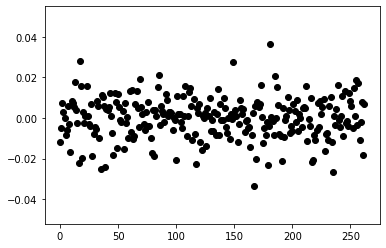

In [20]:
plt.scatter(df.reset_index().index, lr.predict(variables) - df[target], color='black')
plt.show()

In [21]:
r2_score(df[target], lr.predict(variables))

0.9455365997580365

Again, left-handed and switch hitters have negative coefficients for both On-Base and Slugging Percentage when all other ratings are held equal.

In the box-plot above regarding wOBA, there didn't appear to be that negative relationship. Is that true?

In [22]:
target = 'wOBA'
lr.fit(variables, df[target])
dict(zip(variables.columns, lr.coef_))

{'running_ratings_speed': 2.6745723976525477e-05,
 'batting_ratings_vsr_babip': 0.0005386154791231246,
 'batting_ratings_vsr_gap': 0.000149312739554603,
 'batting_ratings_vsr_power': 0.0006072478530126448,
 'batting_ratings_vsr_eye': 0.000347627970780003,
 'batting_ratings_vsr_strikeouts': 0.0005314336906772874,
 'batting_ratings_misc_gb_hitter_type_0': 0.0033472566754788207,
 'batting_ratings_misc_gb_hitter_type_1': 0.0018875792562054949,
 'batting_ratings_misc_gb_hitter_type_2': 0.0002601709262763873,
 'batting_ratings_misc_gb_hitter_type_3': -0.005495006857960702,
 'batting_ratings_misc_fb_hitter_type_0': -0.0006183139849379168,
 'batting_ratings_misc_fb_hitter_type_1': 0.0019383785651219069,
 'batting_ratings_misc_fb_hitter_type_2': -0.0013200645801839876,
 'bats_1': 0.006955452892812953,
 'bats_2': -0.0037835320865571946,
 'bats_3': -0.003171920806255757}

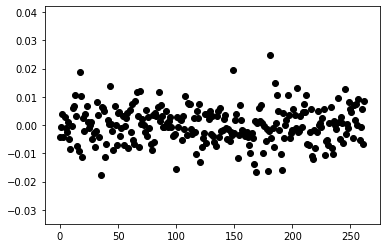

In [23]:
plt.scatter(df.reset_index().index, lr.predict(variables) - df[target], color='black')
plt.show()

In [24]:
r2_score(df[target], lr.predict(variables))

0.9373936076002853

It appears that is false, and opposite side of the plate batters do indeed still have a negative coefficient.

#### Test Two: Batters against RHP in a single OOTP Season

The first test was utilizing a test world that saw all left-handed pitchers retired, using statistics generated through the game's Simulation Module. There has been suggestions that the game engine was never designed for such an occurance (only right-handed pitchers), or perhaps the Simulation Module isn't an accurate way of modeling the engine's performance.

The subsequent tests address this by simulating the 2021 MLB season using the provided MLB quickstart in OOTP 22 Build 34. The only thing adjusted in these tests were the team's home ballpark (to account for park factors), and disabing injuries, player development, and position player fatigue. Additionally, the AI was prevented from making rosters moves throughout this season.

The player ratings in the dataset came directly from the database dumps the game provides, and matched up with the statistics for that player for the season. The first of these two scenarios looks at the splits versuse right-handed pitchers. Instead of keeping split-hitters seperated in these two tests, it's assumed the game automatically has the player hit from the opposite side of the plate.

In [25]:
df = pd.read_csv('OOTP22_Batting_FS2.csv', index_col='ID')
df[['bats', 'gb', 'fb']] = df[['bats', 'gb', 'fb']].astype('category')
df = pd.get_dummies(df)
df.head()

,G,GS,PA,AB,H,2B,3B,HR,RBI,R,...,strikeouts,gb_0,gb_1,gb_2,gb_3,fb_0,fb_1,fb_2,bats_1,bats_2
ID,,,,,,,,,,,,,,,,,,,,,
12,143,104,459,392,69,10,2,23,61,54,...,65,0,0,0,1,0,0,1,0,1
15,149,120,534,480,151,23,9,21,76,81,...,126,0,0,1,0,0,0,1,1,0
16,143,121,513,442,112,27,1,15,67,69,...,83,0,0,1,0,0,0,1,0,1
28,139,112,460,402,113,28,0,15,56,48,...,87,0,0,1,0,0,0,1,1,0
55,142,110,509,457,120,30,4,40,92,75,...,70,0,0,0,1,0,0,1,1,0


In [26]:
variables = df.loc[:,['speed', 'babip', 'gap', 'power', 'eye',
       'strikeouts', 'gb_0', 'gb_1', 'gb_2', 'gb_3', 'fb_0', 'fb_1', 'fb_2',
       'bats_1', 'bats_2']]
variables

,speed,babip,gap,power,eye,strikeouts,gb_0,gb_1,gb_2,gb_3,fb_0,fb_1,fb_2,bats_1,bats_2
ID,,,,,,,,,,,,,,,
12,65,83,76,170,149,65,0,0,0,1,0,0,1,0,1
15,169,134,158,120,96,126,0,0,1,0,0,0,1,1,0
16,63,154,111,147,150,83,0,0,1,0,0,0,1,0,1
28,53,144,105,111,131,87,0,0,1,0,0,0,1,1,0
55,88,104,144,163,108,70,0,0,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36418,65,87,63,50,88,115,0,1,0,0,0,1,0,0,1
36517,52,107,144,117,99,135,0,0,1,0,0,0,1,1,0
36568,43,121,115,113,107,135,0,0,0,1,0,0,1,1,0


With all the variables set, I'll move directly to showing the coefficients for the same four statistics from the first test.

In [27]:
target = 'AVG'

lr.fit(variables, df[target])
dict(zip(variables.columns, lr.coef_))

{'speed': 2.6913699082515405e-05,
 'babip': 0.000677973413723536,
 'gap': 0.00012142051220857784,
 'power': 0.00018036318042640565,
 'eye': -9.618341275495254e-05,
 'strikeouts': 0.0006054176033379418,
 'gb_0': 0.006458929301697677,
 'gb_1': 0.010632180605280546,
 'gb_2': -0.004061035559262339,
 'gb_3': -0.013030074347715859,
 'fb_0': 0.0035718485570942027,
 'fb_1': -0.011703776936314069,
 'fb_2': 0.008131928379219847,
 'bats_1': 0.006477919664323386,
 'bats_2': -0.006477919664323389}

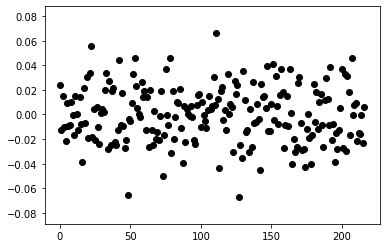

In [28]:
plt.scatter(df.reset_index().index, lr.predict(variables) - df[target], color='black')
plt.show()

In [29]:
r2_score(df[target], lr.predict(variables))

0.5522013029849506

In [30]:
target = 'OBP'

lr.fit(variables, df[target])
dict(zip(variables.columns, lr.coef_))

{'speed': 3.375132796425892e-06,
 'babip': 0.0005261529745084149,
 'gap': 0.00011542278288017667,
 'power': 0.0001823242093012027,
 'eye': 0.000568633278625841,
 'strikeouts': 0.0005666525153120468,
 'gb_0': 0.004975696473598526,
 'gb_1': 0.009564846024311296,
 'gb_2': -0.002199765833388285,
 'gb_3': -0.012340776664521514,
 'fb_0': 0.0030894245710005853,
 'fb_1': -0.009008578748485714,
 'fb_2': 0.005919154177485114,
 'bats_1': 0.006089189914956475,
 'bats_2': -0.0060891899149564796}

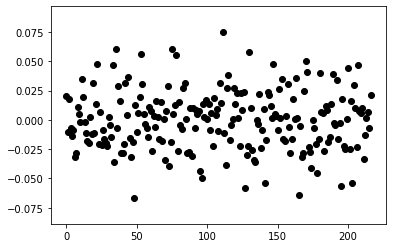

In [31]:
plt.scatter(df.reset_index().index, lr.predict(variables) - df[target], color='black')
plt.show()

In [32]:
r2_score(df[target], lr.predict(variables))

0.44610162087319816

In [33]:
target = 'SLG'

lr.fit(variables, df[target])
dict(zip(variables.columns, lr.coef_))

{'speed': 2.8804946562991062e-05,
 'babip': 0.0006792634253840658,
 'gap': 0.00040057840240886595,
 'power': 0.0012872779630472622,
 'eye': -0.00014359396885600185,
 'strikeouts': 0.000688502690435755,
 'gb_0': 0.013288758854612275,
 'gb_1': 0.020758963244320066,
 'gb_2': -0.007691104759927329,
 'gb_3': -0.02635661733900494,
 'fb_0': -0.0014853016701164455,
 'fb_1': -0.020353297923439397,
 'fb_2': 0.02183859959355581,
 'bats_1': 0.006504141109764227,
 'bats_2': -0.006504141109764232}

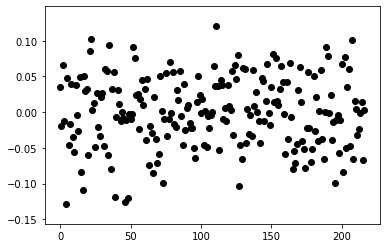

In [34]:
plt.scatter(df.reset_index().index, lr.predict(variables) - df[target], color='black')
plt.show()

In [35]:
r2_score(df[target], lr.predict(variables))

0.431195612913577

In [36]:
target = 'wOBA'

lr.fit(variables, df[target])
dict(zip(variables.columns, lr.coef_))

{'speed': 6.821944799838835e-06,
 'babip': 0.00048590235488079616,
 'gap': 0.0001807322777290025,
 'power': 0.0004974395424027246,
 'eye': 0.00023867432311305056,
 'strikeouts': 0.0004979309540938745,
 'gb_0': 0.006382477949193987,
 'gb_1': 0.012154663847676815,
 'gb_2': -0.0036365239839547393,
 'gb_3': -0.01490061781291603,
 'fb_0': 0.001566795867538456,
 'fb_1': -0.012186911095899264,
 'fb_2': 0.010620115228360786,
 'bats_1': 0.006468176539108849,
 'bats_2': -0.006468176539108852}

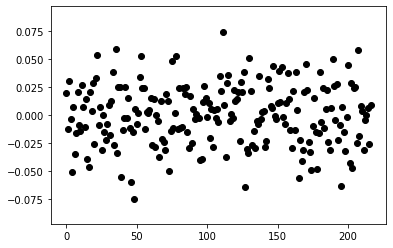

In [37]:
plt.scatter(df.reset_index().index, lr.predict(variables) - df[target], color='black')
plt.show()

In [38]:
r2_score(df[target], lr.predict(variables))

0.3921711517567861

As before, opposite side of the plate batters all receive a penalty compared to their right-handed hitter counterparts. Is this limited to just LHB versus RHP?

#### Test Three: Batters against Left-Handed Pitchers in a single OOTP Season
The test data for this comes from the same world and season that was simulated for the second test. The only difference was using the splits against left-handed pitchers. It should be noted, only qualified batters were used for every test in this notebook.

In [39]:
df = pd.read_csv('OOTP22_Batting_FS3.csv', index_col='ID')
df[['bats', 'gb', 'fb']] = df[['bats', 'gb', 'fb']].astype('category')
df = pd.get_dummies(df)
df.head()

,G,GS,PA,AB,H,2B,3B,HR,RBI,R,...,strikeouts,gb_0,gb_1,gb_2,gb_3,fb_0,fb_1,fb_2,bats_1,bats_2
ID,,,,,,,,,,,,,,,,,,,,,
12,80,41,166,145,30,7,0,9,27,19,...,56,0,0,0,1,0,0,1,0,1
15,90,41,190,168,49,7,3,7,28,23,...,135,0,0,1,0,0,0,1,1,0
16,88,40,175,153,33,9,0,5,15,18,...,68,0,0,1,0,0,0,1,0,1
28,86,39,173,151,47,7,0,6,21,16,...,92,0,0,1,0,0,0,1,1,0
55,77,51,220,192,42,6,0,8,20,28,...,64,0,0,0,1,0,0,1,1,0


In [40]:
variables = df.loc[:,['speed', 'babip', 'gap', 'power', 'eye',
       'strikeouts', 'gb_0', 'gb_1', 'gb_2', 'gb_3', 'fb_0', 'fb_1', 'fb_2',
       'bats_1', 'bats_2']]
variables

,speed,babip,gap,power,eye,strikeouts,gb_0,gb_1,gb_2,gb_3,fb_0,fb_1,fb_2,bats_1,bats_2
ID,,,,,,,,,,,,,,,
12,65,73,74,140,146,56,0,0,0,1,0,0,1,0,1
15,169,126,122,92,104,135,0,0,1,0,0,0,1,1,0
16,63,117,74,111,113,68,0,0,1,0,0,0,1,0,1
28,53,156,112,118,136,92,0,0,1,0,0,0,1,1,0
55,88,103,136,165,126,64,0,0,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36418,65,83,54,43,93,111,0,1,0,0,0,1,0,0,1
36517,52,114,160,121,108,143,0,0,1,0,0,0,1,1,0
36568,43,132,120,120,113,138,0,0,0,1,0,0,1,1,0


As before, the same four batting statistics and their coefficients in a simple linear regression model.

In [41]:
target = 'AVG'

lr.fit(variables, df[target])
dict(zip(variables.columns, lr.coef_))

{'speed': -4.245424334078681e-05,
 'babip': 0.0008188619979071176,
 'gap': 0.0002146728232400121,
 'power': 0.0003426392565832736,
 'eye': -1.5896784886733893e-05,
 'strikeouts': 0.0005987033250235257,
 'gb_0': 0.007622190916927183,
 'gb_1': 0.004039265561112323,
 'gb_2': -0.0060657984189734756,
 'gb_3': -0.005595658059066039,
 'fb_0': -0.005662629876491178,
 'fb_1': 0.00676030440489771,
 'fb_2': -0.001097674528406522,
 'bats_1': -0.007736113534257997,
 'bats_2': 0.007736113534257996}

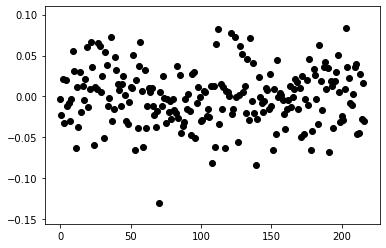

In [42]:
plt.scatter(df.reset_index().index, lr.predict(variables) - df[target], color='black')
plt.show()

In [43]:
r2_score(df[target], lr.predict(variables))

0.39462051602336856

In [44]:
target = 'OBP'

lr.fit(variables, df[target])
dict(zip(variables.columns, lr.coef_))

{'speed': -5.5853840425262744e-05,
 'babip': 0.000788814217615308,
 'gap': 0.0001919037492225367,
 'power': 0.00031670405712581163,
 'eye': 0.000574229606122465,
 'strikeouts': 0.0005506166528420916,
 'gb_0': 0.007094590083787408,
 'gb_1': 0.000702450562149101,
 'gb_2': -0.0013893057232750587,
 'gb_3': -0.006407734922661455,
 'fb_0': -0.006001647071020469,
 'fb_1': 0.009246253473248997,
 'fb_2': -0.0032446064022285145,
 'bats_1': -0.005919168280364638,
 'bats_2': 0.005919168280364639}

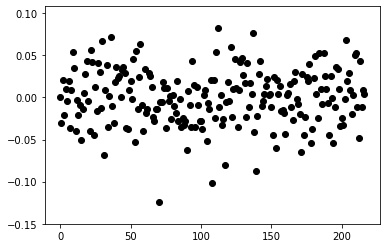

In [45]:
plt.scatter(df.reset_index().index, lr.predict(variables) - df[target], color='black')
plt.show()

In [46]:
r2_score(df[target], lr.predict(variables))

0.4445260272410734

In [47]:
target = 'SLG'

lr.fit(variables, df[target])
dict(zip(variables.columns, lr.coef_))

{'speed': 1.6125935326007586e-05,
 'babip': 0.0011123762431194271,
 'gap': 0.00043692670887099703,
 'power': 0.0017676746975064579,
 'eye': 6.779020099437926e-06,
 'strikeouts': 0.0009175535843315606,
 'gb_0': -0.014534506174004749,
 'gb_1': 0.019854613979153935,
 'gb_2': -0.006327499691071586,
 'gb_3': 0.0010073918859224017,
 'fb_0': 0.011908796292248749,
 'fb_1': -0.0019559352885150515,
 'fb_2': -0.009952861003733725,
 'bats_1': -0.01014306633713237,
 'bats_2': 0.010143066337132354}

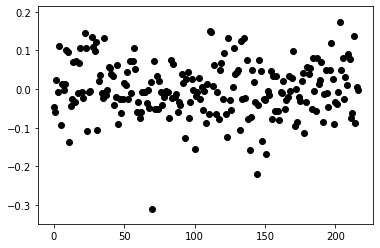

In [48]:
plt.scatter(df.reset_index().index, lr.predict(variables) - df[target], color='black')
plt.show()

In [49]:
r2_score(df[target], lr.predict(variables))

0.42380816857157155

In [50]:
target = 'wOBA'

lr.fit(variables, df[target])
dict(zip(variables.columns, lr.coef_))

{'speed': -1.7121804211821632e-05,
 'babip': 0.0007344849744313703,
 'gap': 0.0002483591027154725,
 'power': 0.0006920447837294832,
 'eye': 0.0003037268644274827,
 'strikeouts': 0.0005470264330103073,
 'gb_0': 0.000650128201414937,
 'gb_1': 0.005849605694305061,
 'gb_2': -0.0029738533549679984,
 'gb_3': -0.003525880540752004,
 'fb_0': -0.0006397801180450442,
 'fb_1': 0.004407103124202981,
 'fb_2': -0.0037673230061579395,
 'bats_1': -0.006981278215469833,
 'bats_2': 0.006981278215469829}

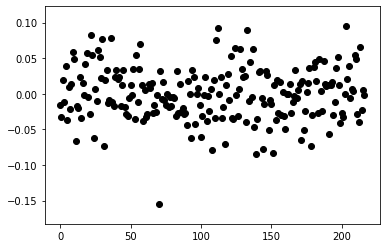

In [51]:
plt.scatter(df.reset_index().index, lr.predict(variables) - df[target], color='black')
plt.show()

In [52]:
r2_score(df[target], lr.predict(variables))

0.40443905116871626

Again, every test shows that opposite side of the plater batters receive a penalty.

Is this something unique to OOTP22 or was this how OOTP21 acted?

#### Test 4: Batters against only Right-Handed Pitchers in OOTP21 using the Simulation Module.

The setup for this test is exactly the same as the first test: All left-handed pitchers were retired at the start of a MLB Quickstart, except it occured in OOTP 21.6 Build 83. Each team played the other 29 teams in the league a total of 2,430 games. All switch-hitters that were included in the dataset had their batting side set to left (2) before they were loaded into the notebook.

In [53]:
df = pd.read_csv('OOTP21_Batting.csv', index_col='player_id')
df[['bats', 'batting_ratings_misc_gb_hitter_type', 'batting_ratings_misc_fb_hitter_type']] = df[['bats', 'batting_ratings_misc_gb_hitter_type', 'batting_ratings_misc_fb_hitter_type']].astype('category')

df = pd.get_dummies(df)
df.head()

,batting_ratings_vsr_gap,batting_ratings_vsr_eye,batting_ratings_vsr_strikeouts,batting_ratings_vsr_power,batting_ratings_vsr_babip,running_ratings_speed,avg,obp,slg,woba,batting_ratings_misc_gb_hitter_type_0,batting_ratings_misc_gb_hitter_type_1,batting_ratings_misc_gb_hitter_type_2,batting_ratings_misc_gb_hitter_type_3,batting_ratings_misc_fb_hitter_type_0,batting_ratings_misc_fb_hitter_type_1,batting_ratings_misc_fb_hitter_type_2,bats_1,bats_2
player_id,,,,,,,,,,,,,,,,,,,
263,148,120,66,140,123,132,0.217,0.279,0.376,0.2901,0,1,0,0,1,0,0,1,0
275,100,121,116,86,122,97,0.241,0.305,0.336,0.2881,0,1,0,0,1,0,0,0,1
1573,121,125,60,114,96,9,0.184,0.251,0.298,0.2483,0,0,1,0,1,0,0,1,0
1934,116,120,95,114,98,77,0.218,0.281,0.341,0.2782,0,1,0,0,0,0,1,1,0
22807,103,106,109,71,131,162,0.243,0.294,0.333,0.2806,1,0,0,0,1,0,0,0,1


In [54]:
variables = df.loc[:,['batting_ratings_vsr_gap', 'batting_ratings_vsr_eye',
       'batting_ratings_vsr_strikeouts', 'batting_ratings_vsr_power',
       'batting_ratings_vsr_babip', 'running_ratings_speed', 'batting_ratings_misc_gb_hitter_type_0',
       'batting_ratings_misc_gb_hitter_type_1',
       'batting_ratings_misc_gb_hitter_type_2',
       'batting_ratings_misc_gb_hitter_type_3',
       'batting_ratings_misc_fb_hitter_type_0',
       'batting_ratings_misc_fb_hitter_type_1',
       'batting_ratings_misc_fb_hitter_type_2', 'bats_1', 'bats_2']]

variables

,batting_ratings_vsr_gap,batting_ratings_vsr_eye,batting_ratings_vsr_strikeouts,batting_ratings_vsr_power,batting_ratings_vsr_babip,running_ratings_speed,batting_ratings_misc_gb_hitter_type_0,batting_ratings_misc_gb_hitter_type_1,batting_ratings_misc_gb_hitter_type_2,batting_ratings_misc_gb_hitter_type_3,batting_ratings_misc_fb_hitter_type_0,batting_ratings_misc_fb_hitter_type_1,batting_ratings_misc_fb_hitter_type_2,bats_1,bats_2
player_id,,,,,,,,,,,,,,,
263,148,120,66,140,123,132,0,1,0,0,1,0,0,1,0
275,100,121,116,86,122,97,0,1,0,0,1,0,0,0,1
1573,121,125,60,114,96,9,0,0,1,0,1,0,0,1,0
1934,116,120,95,114,98,77,0,1,0,0,0,0,1,1,0
22807,103,106,109,71,131,162,1,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57880,137,127,84,106,97,170,0,1,0,0,1,0,0,1,0
57967,131,89,158,110,89,124,1,0,0,0,1,0,0,1,0
58144,145,119,101,144,116,4,0,0,1,0,0,0,1,0,1


Again, the same four statistcs and their coefficients.

In [55]:
target = 'avg'

lr.fit(variables, df[target])
dict(zip(variables.columns, lr.coef_))

{'batting_ratings_vsr_gap': 6.679228312065005e-05,
 'batting_ratings_vsr_eye': -3.0764477025254765e-05,
 'batting_ratings_vsr_strikeouts': 0.0006144342391833212,
 'batting_ratings_vsr_power': 0.0001927910534394391,
 'batting_ratings_vsr_babip': 0.0006566909260157941,
 'running_ratings_speed': 5.66307653869181e-06,
 'batting_ratings_misc_gb_hitter_type_0': 0.0020178698334203105,
 'batting_ratings_misc_gb_hitter_type_1': 0.0041494384101570855,
 'batting_ratings_misc_gb_hitter_type_2': -0.00022683346300995775,
 'batting_ratings_misc_gb_hitter_type_3': -0.005940474780567433,
 'batting_ratings_misc_fb_hitter_type_0': -0.0001493901555282352,
 'batting_ratings_misc_fb_hitter_type_1': -0.00018967747916081958,
 'batting_ratings_misc_fb_hitter_type_2': 0.00033906763468905606,
 'bats_1': -0.00023360629344976915,
 'bats_2': 0.00023360629344976785}

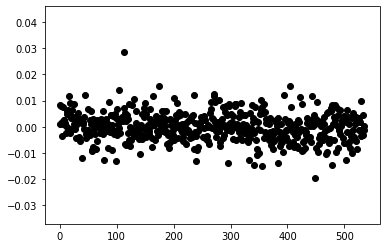

In [56]:
plt.scatter(df.reset_index().index, lr.predict(variables) - df[target], color='black')
plt.show()

In [57]:
r2_score(df[target], lr.predict(variables))

0.9621428735563833

In [58]:
target = 'obp'

lr.fit(variables, df[target])
dict(zip(variables.columns, lr.coef_))

{'batting_ratings_vsr_gap': 9.082230640559512e-05,
 'batting_ratings_vsr_eye': 0.0006297318591834913,
 'batting_ratings_vsr_strikeouts': 0.0005843627966444447,
 'batting_ratings_vsr_power': 0.00019169281518269566,
 'batting_ratings_vsr_babip': 0.0006014238836418752,
 'running_ratings_speed': 7.73086063489378e-06,
 'batting_ratings_misc_gb_hitter_type_0': 0.0015225813442299018,
 'batting_ratings_misc_gb_hitter_type_1': 0.004450303391441519,
 'batting_ratings_misc_gb_hitter_type_2': -0.0004121592062115893,
 'batting_ratings_misc_gb_hitter_type_3': -0.0055607255294598265,
 'batting_ratings_misc_fb_hitter_type_0': -0.00020086481526877288,
 'batting_ratings_misc_fb_hitter_type_1': -0.0006270720490718295,
 'batting_ratings_misc_fb_hitter_type_2': 0.0008279368643406029,
 'bats_1': -0.0024529172481692193,
 'bats_2': 0.002452917248169218}

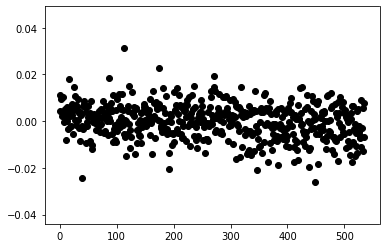

In [59]:
plt.scatter(df.reset_index().index, lr.predict(variables) - df[target], color='black')
plt.show()

In [60]:
r2_score(df[target], lr.predict(variables))

0.9336539554727651

In [61]:
target = 'slg'

lr.fit(variables, df[target])
dict(zip(variables.columns, lr.coef_))

{'batting_ratings_vsr_gap': 0.0004953871347480087,
 'batting_ratings_vsr_eye': -7.111090080191298e-05,
 'batting_ratings_vsr_strikeouts': 0.0007071819533859768,
 'batting_ratings_vsr_power': 0.0010917807834734366,
 'batting_ratings_vsr_babip': 0.0006379428645604492,
 'running_ratings_speed': 3.766563112710721e-05,
 'batting_ratings_misc_gb_hitter_type_0': 0.0003367128755983973,
 'batting_ratings_misc_gb_hitter_type_1': 0.005331606189986567,
 'batting_ratings_misc_gb_hitter_type_2': -0.0017770710545650656,
 'batting_ratings_misc_gb_hitter_type_3': -0.003891248011019897,
 'batting_ratings_misc_fb_hitter_type_0': -0.0005897166346795753,
 'batting_ratings_misc_fb_hitter_type_1': -0.0012446911035012133,
 'batting_ratings_misc_fb_hitter_type_2': 0.0018344077381807892,
 'bats_1': -0.0031713383600843084,
 'bats_2': 0.003171338360084307}

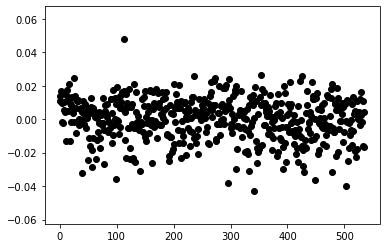

In [62]:
plt.scatter(df.reset_index().index, lr.predict(variables) - df[target], color='black')
plt.show()

In [63]:
r2_score(df[target], lr.predict(variables))

0.9433596640618284

In [64]:
target = 'woba'

lr.fit(variables, df[target])
dict(zip(variables.columns, lr.coef_))

{'batting_ratings_vsr_gap': 0.0002204038061038758,
 'batting_ratings_vsr_eye': 0.00032245344754936464,
 'batting_ratings_vsr_strikeouts': 0.0005475850353326288,
 'batting_ratings_vsr_power': 0.0005069787588925306,
 'batting_ratings_vsr_babip': 0.0005327000254594797,
 'running_ratings_speed': 1.709678742653076e-05,
 'batting_ratings_misc_gb_hitter_type_0': 0.0009067384234499978,
 'batting_ratings_misc_gb_hitter_type_1': 0.004276745573563777,
 'batting_ratings_misc_gb_hitter_type_2': -0.0009282899676932923,
 'batting_ratings_misc_gb_hitter_type_3': -0.004255194029320478,
 'batting_ratings_misc_fb_hitter_type_0': -0.00029819357305254003,
 'batting_ratings_misc_fb_hitter_type_1': -0.0008259049730237955,
 'batting_ratings_misc_fb_hitter_type_2': 0.0011240985460763357,
 'bats_1': -0.0024840568306629235,
 'bats_2': 0.0024840568306629227}

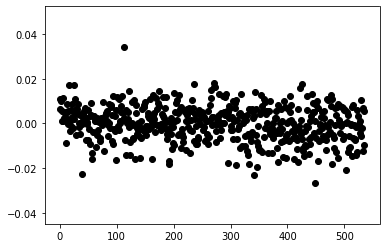

In [65]:
plt.scatter(df.reset_index().index, lr.predict(variables) - df[target], color='black')
plt.show()

In [66]:
r2_score(df[target], lr.predict(variables))

0.9367543941377255

As expected, conventional baseball wisdom has returned, and left-handed batters no longer receive a penalty against right-handed pitchers. 

#### My Conclusions
The latest version of Out of the Park Baseball no longer accurately models that advantage opposite side of the plate batters have against pitchers.